# Thresholds Notebook

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [3]:
from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [4]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

RANDOM_SEED = 1

## Compare all

In [5]:
from stabilize2p import threshold

methods = [
    threshold.otsu,
    threshold.triangle,
    threshold.watershed
]

otsu: 15,415
triangle: 10,192
watershed: 8,340


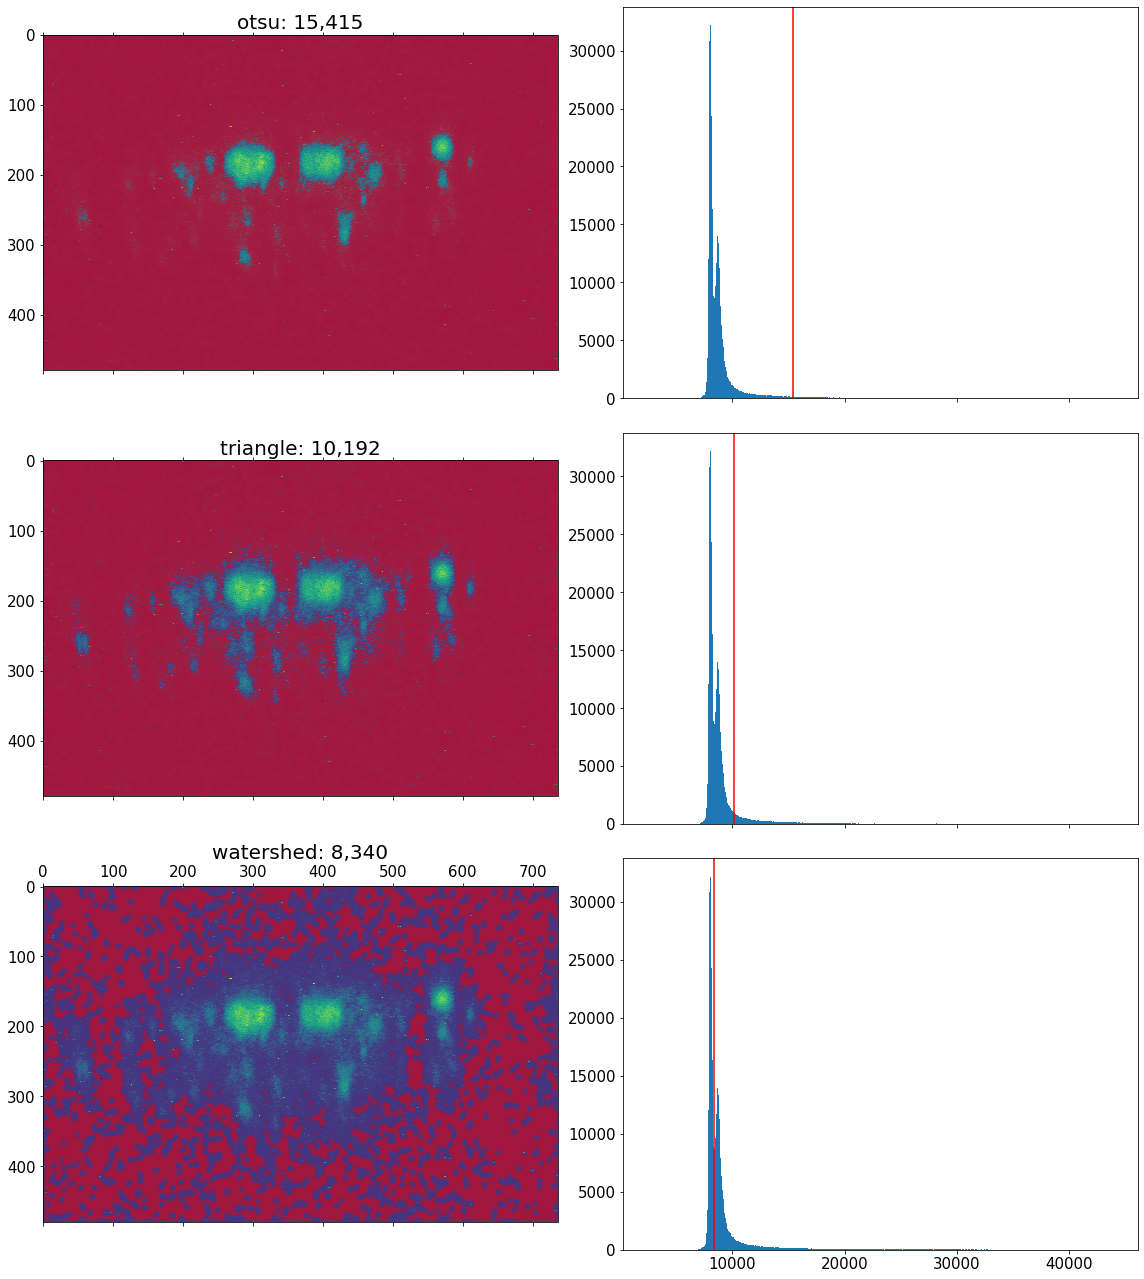

In [8]:
# example
path = orig_examples[0]
image = tiff.imread(path, key=0)

_, axes = plt.subplots(len(methods), 2, figsize=(8*2, 6*len(methods)), sharey='col', sharex='col')

# apply thresholds
for meth, ax in zip(methods, axes):
    th = meth(image)
    title = f'{meth.__name__}: {th:,.0f}'
    print(title)
    
    ax[0].matshow(image)

    alpha = 0.5
    mask = (image < th).astype(float) * alpha
    mask = np.tile(mask[..., np.newaxis], (1, 1, 4))
    mask[..., [1, 2]] = 0.0
    mask[..., 0] = 1.0
    ax[0].imshow(mask)
    ax[0].set_title(title)

    # histogram
    ax[1].hist(image.ravel(), bins=600)
    ax[1].axvline(th, c='r')

plt.tight_layout()
plt.show();

In [10]:
from stabilize2p import threshold


def gen(video, meth):
    thresh = []
    for i, frame in enumerate(frame_gen(video)):
        thresh += [meth(frame)]
    thresh = np.mean(thresh)
    print(f'{thresh=}')

    for i, frame in enumerate(frame_gen(video)):
        idx = frame < thresh

        frame = cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)        

        # threshold circle
        frame[idx] = [100, 0, 0]
        yield frame

video = tiff.imread(orig_examples[0], key=range(200))
for meth in methods:
    print(str(meth.__name__))
    make_video(f'thresholds/{meth.__name__}', gen(video, meth), output_format='mp4')

otsu
thresh=73.97517647058822


200it [00:01, 155.69it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.71s)
triangle
thresh=44.7453137254902


200it [00:01, 143.94it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.07s)
watershed
thresh=33.215206249999994


200it [00:01, 172.46it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.49s)


In [5]:
Video(f'thresholds/otsu.mp4')

In [11]:
Video(f'thresholds/triangle.mp4')

In [6]:
Video(f'thresholds/watershed.mp4')